In [8]:
import pandas as pd
import numpy as np
import msprime
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDiagonalNormal
import seaborn as sns
import matplotlib.pyplot as plt

import simulation
from topology import nodes_admix,nodes_simple,events_admix,events_simple
from likelihood import create_nodes_map,mig_matrix, expected_ratio

In [2]:
# Show the pipeline of how ADVI estimates the parameters.
# First simulate synthetic data using given parameters. 


## The naive model does not involve admixture so only effective population sizes and times are specified.
## Notice that the model simulate diploid data, so a N_e = 5000 means the rate of coalesce is 1/5000*2.
N = [2500,5000,2500,1000,10000]
T = [15,30]
## The length bins we are interested.
L = [0,0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.8,0.9,1,2,3,4,5,100] 

## data_mean reports the matrix of avg sharing fractions between populations, data_var is the bootstrap variance of this avg.
## There are len(L)-1 matrices
data_mean,data_var = simulation.popn3_simple_data(N,T,L,1000)

In [6]:
# We first check if this one realisation fits the theoretical values.
T_diff = [T[0]]
for i in range(len(T)-1):
    T_diff.append(T[i+1]-T[i])
T_diff.append(10000000)
out = []
#since using N to simulate is equvalent to rate of coalesce 1/(2N)
real_N = [i*2 for i in N]
for i in range(len(L)-1):
    u = L[i]
    v = L[i+1]
    true_mean = expected_ratio(N=real_N,d=3,T=T_diff,nodes=nodes_simple, events=events_simple,u=u,v=v,l=100)
    out.append(true_mean)
out

[tensor([[0.9461, 0.9518, 0.9518],
         [0.9518, 0.9433, 0.9447],
         [0.9518, 0.9447, 0.9419]]),
 tensor([[0.0235, 0.0236, 0.0236],
         [0.0236, 0.0234, 0.0235],
         [0.0236, 0.0235, 0.0234]]),
 tensor([[0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048]]),
 tensor([[0.0032, 0.0032, 0.0032],
         [0.0032, 0.0032, 0.0032],
         [0.0032, 0.0032, 0.0032]]),
 tensor([[0.0023, 0.0023, 0.0023],
         [0.0023, 0.0023, 0.0023],
         [0.0023, 0.0023, 0.0023]]),
 tensor([[0.0017, 0.0018, 0.0018],
         [0.0018, 0.0017, 0.0017],
         [0.0018, 0.0017, 0.0017]]),
 tensor([[0.0014, 0.0014, 0.0014],
         [0.0014, 0.0014, 0.0014],
         [0.0014, 0.0014, 0.0014]]),
 tensor([[0.0011, 0.0011, 0.0011],
         [0.0011, 0.0011, 0.0011],
         [0.0011, 0.0011, 0.0011]]),
 tensor([[0.0009, 0.0009, 0.0009],
         [0.0009, 0.0009, 0.0009],
         [0.0009, 0.0009, 0.0009]]),
 tensor([[0.0007, 0.0007, 0.0007],
  

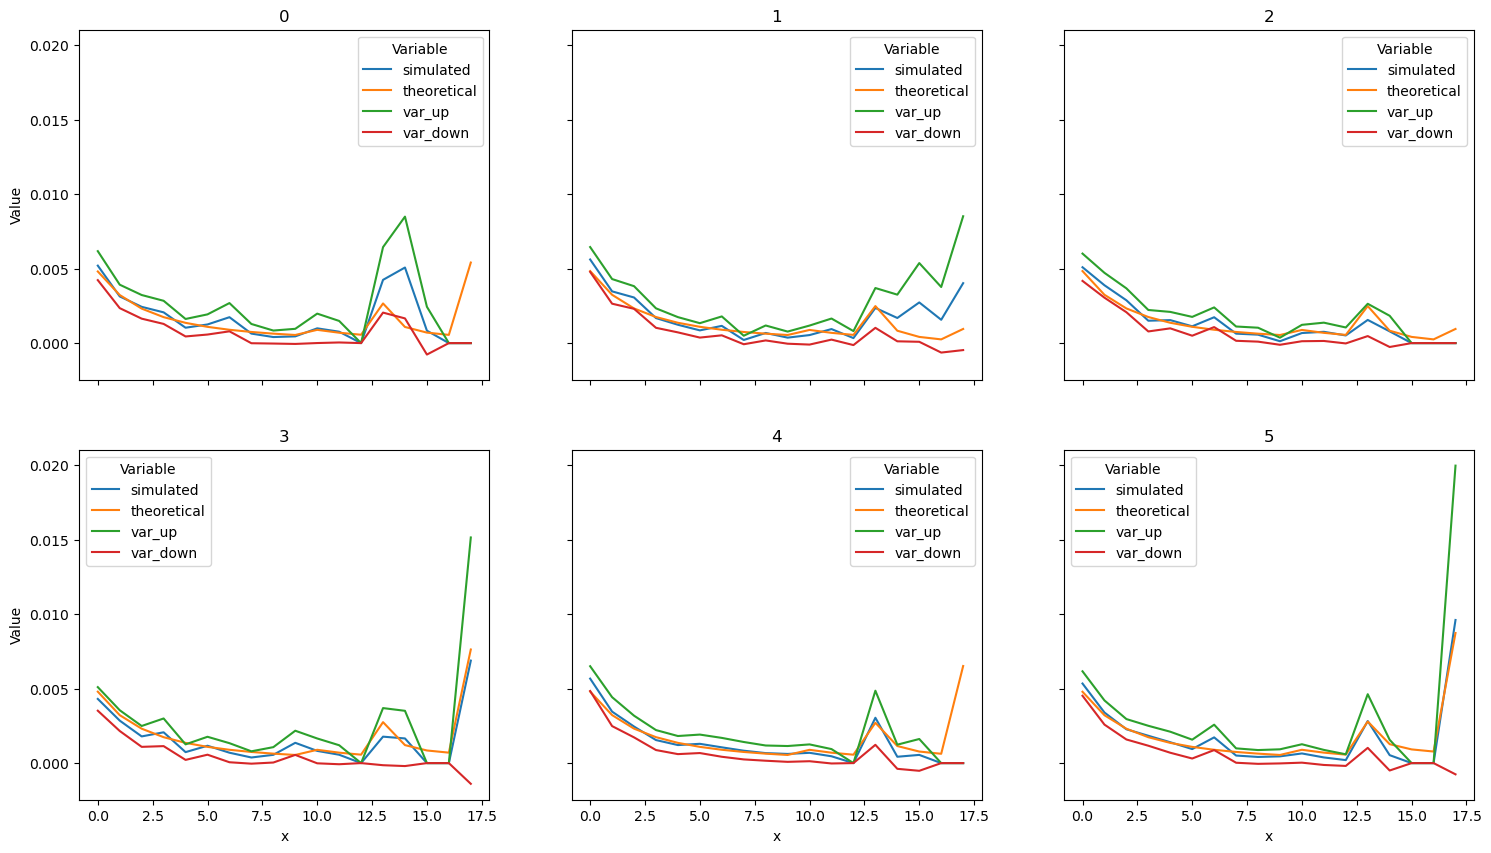

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
cnt = 0
dfs = []
for i in range(len(data_mean[0])):
    for j in range(i,len(data_mean[0])):
        data = pd.DataFrame({
            'simulated': [a[i][j] for a in data_mean[2:]],
            'theoretical':[a[i][j].item() for a in out[2:]],
            'var_up':[1.96*np.sqrt(a[i][j]) + b[i][j] for a,b in zip(data_var[2:],data_mean[2:])],
            'var_down':[b[i][j]-1.96*np.sqrt(a[i][j]) for a,b in zip(data_var[2:],data_mean[2:])],
            'x' : np.arange(len(data_mean[2:])),
            'group': cnt
        })
        dfs.append(data)
        cnt += 1
data = pd.concat(dfs,ignore_index=True)
data_melted = data.melt(id_vars=['x', 'group'], value_vars=['simulated', 'theoretical', 'var_up','var_down'],
                        var_name='Variable', value_name='Value')

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each group in a subplot
for i, group in enumerate(data['group'].unique()):
    ax = axes[i]
    sns.lineplot(x='x', y='Value', hue='Variable', data=data_melted[data_melted['group'] == group], ax=ax)
    ax.set_title(group)
    ax.set_xlabel('x')
    ax.set_ylabel('Value')
    ax.legend(title='Variable')
#sns.lineplot(data=data,x='x',y='theoretical')
#plt.show()
#fig, axes = plt.subplots(3, 3, figsize=(15, 15))
#axes = axes.flatten()


We now look at the model specification and the ADVI.

In [52]:
# Prepare the data.
dfs = []
for i in range(len(data_mean[0])):
    for j in range(i,len(data_mean[0])):
        for k in range(len(L)):
            data = pd.DataFrame({
                'obs': [a[i][j] for a in data_mean],
                'var':[a[i][j] for a in data_var],
                'groupA':i,
                'groupB' :j,
                'bin':[i for i in range(len(L)-1)]
            })
        dfs.append(data)
data = pd.concat(dfs,ignore_index=True)
data_melted = data.melt(id_vars=[ 'groupA','groupB','bin','var'], value_vars=['obs'],
                        var_name='Variable', value_name='Value')

# Define the Model
def popn3_simple_model(L, data_melted, nodes, events):
    # This prior to make mean 5000 variance 20000.
    N1 = pyro.sample("N1", dist.Gamma(1250, 0.25))
    N2 = pyro.sample("N2", dist.Gamma(1250, 0.25))
    N3 = pyro.sample("N3", dist.Gamma(1250, 0.25))
    N4 = pyro.sample("N4", dist.Gamma(1250, 0.25))
    N5 = pyro.sample("N5", dist.Gamma(1250, 0.25))
    # Make the time difference mean 30.
    T1 = pyro.sample("T1", dist.Exponential(30))
    T2 = pyro.sample("T2", dist.Exponential(30))
    
    N = [N1,N2,N3,N4,N5]
    T = [T1,T2,1000000]
    

    for i in range(len(data_melted)):
        if data_melted.loc[i,'var'] != 0: 
            u = L[data_melted.loc[i,'bin']]
            v = L[data_melted.loc[i,'bin']+1] 
            d = 3
            mean = expected_ratio(N=N, d=3, T=T, nodes=nodes, events=events, u=u, v=v, l=100)[data_melted.loc[i, 'groupA']][data_melted.loc[i, 'groupB']]
            pyro.sample(f"obs_{i}", dist.Normal(mean, torch.sqrt(torch.tensor(data_melted.loc[i, 'var']))), obs=data_melted.loc[i, 'Value'])


In [ ]:
def guide_custome()

In [48]:
n_steps = 2000
losses = []

for step in range(n_steps):
    loss = svi.step(L=L, data_melted=data_melted, nodes=nodes_simple, events=events_simple)
    losses.append(loss)
    if step % 2 == 0:
        print(f"Step {step}: Loss = {loss}")

AssertionError: 

In [19]:
def model(data):
    # define the hyperparameters that control the Beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the Beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    with pyro.plate("data", len(data)):
        # Observe datapoint i using the Bernoulli likelihood Bernoulli(f)
        pyro.sample("obs", dist.Bernoulli(f), obs=data)


g = AutoDiagonalNormal(model)


adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)

# Create the SVI object
svi = SVI(model, g, optimizer, loss=Trace_ELBO())
n_steps = 2000
losses = []
data = torch.tensor([1.0]*6 + [0.0]*4) 
for step in range(n_steps):
    loss = svi.step(data)
    losses.append(loss)
    if step % 2 == 0:
        print(f"Step {step}: Loss = {loss}")

Step 0: Loss = 7.347453236579895
Step 2: Loss = 7.301450133323669
Step 4: Loss = 7.252911031246185
Step 6: Loss = 7.151834607124329
Step 8: Loss = 6.957284688949585
Step 10: Loss = 6.982222259044647
Step 12: Loss = 7.144120812416077
Step 14: Loss = 7.1203635931015015
Step 16: Loss = 7.103638529777527
Step 18: Loss = 7.11624950170517
Step 20: Loss = 7.139369964599609
Step 22: Loss = 7.134573996067047
Step 24: Loss = 7.03779536485672
Step 26: Loss = 7.073515176773071
Step 28: Loss = 7.035019218921661
Step 30: Loss = 7.013216912746429
Step 32: Loss = 7.000499904155731
Step 34: Loss = 7.027193605899811
Step 36: Loss = 6.999359488487244
Step 38: Loss = 7.039695918560028
Step 40: Loss = 7.610972285270691
Step 42: Loss = 7.012669861316681
Step 44: Loss = 6.963928580284119
Step 46: Loss = 7.012559294700623
Step 48: Loss = 6.9401819705963135
Step 50: Loss = 7.398707866668701
Step 52: Loss = 7.087959289550781
Step 54: Loss = 7.335169553756714
Step 56: Loss = 6.948752760887146
Step 58: Loss = 7.0

AutoDiagonalNormal.loc = [0.1755434]
AutoDiagonalNormal.scale = [0.36387974]


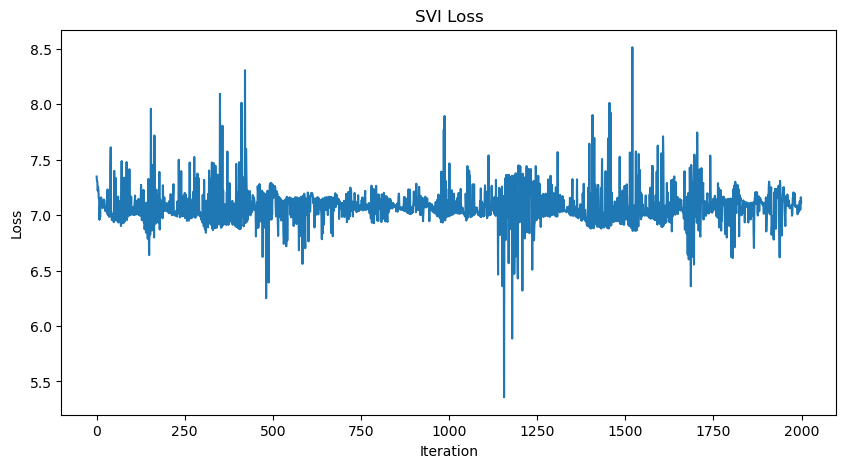

In [20]:
for name, value in pyro.get_param_store().items():
    print(f"{name} = {value.detach().cpu().numpy()}")

# Plot the loss over iterations
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('SVI Loss')
plt.show()